Classical shadows
=================

::: {.meta}
:property=\"og:description\": Learn how to construct classical shadows
and use them to estimate observables. :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets//atom_shadow.png>
:::

::: {.related}
tutorial\_measurement\_optimize Measurement optimization quantum\_volume
Quantum volume tutorial\_quantum\_metrology Variationally optimizing
measurement protocols
:::

*Authors: Roeland Wiersema and Brian Doolittle (Xanadu Residents) ---
Posted: 14 June 2021. Last updated: 14 June 2021.*

![](../_static/demonstration_assets/classical_shadows/atom_shadow.png){.align-center
width="75.0%"}

Estimating properties of unknown quantum states is a key objective of
quantum information science and technology. For example, one might want
to check whether an apparatus prepares a particular target state, or
verify that an unknown system is entangled. In principle, any unknown
quantum state can be fully characterized by [quantum state
tomography](https://arxiv.org/pdf/quant-ph/0302028.pdf). However, this
procedure requires accurate expectation values for a set of observables
whose size grows exponentially with the number of qubits. A potential
workaround for these scaling concerns is provided by the classical
shadow approximation introduced in a recent paper by Huang et al..

The approximation is an efficient protocol for constructing a *classical
shadow* representation of an unknown quantum state. The classical shadow
can be used to estimate properties such as quantum state fidelity,
expectation values of Hamiltonians, entanglement witnesses, and
two-point correlators.

![(Image from Huang et
al..)](../_static/demonstration_assets/classical_shadows/classical_shadow_overview.png){.align-center
width="90.0%"}

In this demo, we use PennyLane to obtain classical shadows of a quantum
state prepared by a quantum circuit, and use them to reconstruct the
state and estimate expectation values of observables.


Constructing a Classical Shadow
===============================

Classical shadow estimation relies on the fact that for a particular
choice of measurement, we can efficiently store snapshots of the state
that contain enough information to accurately predict linear functions
of observables. Depending on what type of measurements we choose, we
have an information-theoretic bound that allows us to control the
precision of our estimator.

Let us consider an $n$-qubit quantum state $\rho$ (prepared by a
circuit) and apply a random unitary $U$ to the state:

$$|\psi\rangle \to U |\psi\rangle $$

$$\rho=|\psi\rangle\langle\psi| \to U|\psi\rangle\langle\psi|U^\dagger$$

$$\rho \to U \rho U^\dagger.$$

Next, we measure in the computational basis and obtain a bit string of
outcomes $|b\rangle = |0011\ldots10\rangle$. If the unitaries $U$ are
chosen at random from a particular ensemble, then we can store the
reverse operation $U^\dagger |b\rangle\langle b| U$ efficiently in
classical memory. We call this a *snapshot* of the state. Moreover, we
can view the average over these snapshots as a measurement channel:

$$\mathbb{E}\left[U^\dagger |b\rangle\langle b| U\right] = \mathcal{M}(\rho).$$

If the ensemble of unitaries defines a tomographically complete set of
measurements, we can invert the channel and reconstruct the state:

$$\rho = \mathbb{E}\left[\mathcal{M}^{-1}\left(U^\dagger |b\rangle\langle b| U \right)\right].$$

If we apply the procedure outlined above $N$ times, then the collection
of inverted snapshots is what we call the *classical shadow*

$$S(\rho,N) = \left\{\hat{\rho}_1= \mathcal{M}^{-1}\left(U_1^\dagger |b_1\rangle\langle b_1| U_1 \right)
,\ldots, \hat{\rho}_N= \mathcal{M}^{-1}\left(U_N^\dagger |b_N\rangle\langle b_N| U_N \right)
\right\}.$$

The inverted channel is not physical, i.e., it is not completely postive
and trace preserving (CPTP). However, this is of no concern to us, since
all we care about is efficiently applying this inverse channel to the
observed snapshots as a post-processing step.

Since the shadow approximates $\rho$, we can now estimate **any**
observable with the empirical mean:

$$\langle O \rangle = \frac{1}{N}\sum_i \text{Tr}{\hat{\rho}_i O}.$$

Note that the classical shadow is independent of the observables we want
to estimate, as $S(\rho,N)$ contains only information about the state!

Furthermore, the authors of prove that with a shadow of size $N$, we can
predict $M$ arbitary linear functions
$\text{Tr}{O_1\rho},\ldots,\text{Tr}{O_M \rho}$ up to an additive error
$\epsilon$ if
$N\geq \mathcal{O}\left(\log{M} \max_i ||O_i||^2_{\text{shadow}}/\epsilon^2\right)$.
The shadow norm $||O_i||^2_{\text{shadow}}$ depends on the unitary
ensemble that is chosen.

Two different ensembles can be considered for selecting the random
unitaries $U$:

1.  Random $n$-qubit Clifford circuits.
2.  Tensor products of random single-qubit Clifford circuits.

Although ensemble 1 leads to the most powerful estimators, it comes with
serious practical limitations since $n^2 / \log(n)$ entangling gates are
required to sample the Clifford circuit. The snapshots of both ensembles
can be stored efficiently using the [stabilizer
formalism](https://arxiv.org/abs/quant-ph/9705052). Single-qubit
Clifford circuits rotate the measurement basis to one of the Pauli
eigenbases, so ensemble 2 is equivalent to measuring single shots of
single-qubit Pauli observables on all qubits. For the purposes of this
demo we focus on ensemble 2, which is a more NISQ-friendly approach.

This ensemble comes with a significant drawback: the shadow norm
$||O_i||^2_{\text{shadow}}$ becomes dependent on the locality $k$ of the
observables that we want to estimate:

$$||O_i||^2_{\text{shadow}} \leq 4^k ||O_i||_\infty^2.$$

Say that we want to estimate the single expectation value of a Pauli
observable $\langle X_1 \otimes X_2 \otimes \ldots \otimes X_n \rangle$.
Estimating this from repeated measurements would require $1/\epsilon^2$
samples, whereas we would need an exponentially large shadow due to the
$4^n$ appearing in the bound. Therefore, classical shadows based on
Pauli measurements only offer an advantage when we have to measure a
large number of observables with modest locality.

We will now demonstrate how to obtain classical shadows using PennyLane.


In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(666)

A classical shadow is a collection of $N$ individual snapshots
$\hat{\rho}_i$. Each snapshot is obtained with the following procedure:

1.  The quantum state $\rho$ is prepared with a circuit.
2.  A unitary $U$ is randomly selected from the ensemble and applied to
    $\rho$.
3.  A computational basis measurement is performed.
4.  The snapshot is recorded as the observed eigenvalue $1,-1$ for
    $|0\rangle,|1\rangle$, respectively, and the index of the randomly
    selected unitary $U$.

To obtain a classical shadow using PennyLane, we design the
`calculate_classical_shadow` function below. This function obtains a
classical shadow for the state prepared by an input `circuit_template`.


In [2]:
def calculate_classical_shadow(circuit_template, params, shadow_size, num_qubits):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Args:
        circuit_template (function): A Pennylane QNode.
        params (array): Circuit parameters.
        shadow_size (int): The number of snapshots in the shadow.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes (-1, 1)
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
        Each row of the arrays corresponds to a distinct snapshot or sample while each
        column corresponds to a different qubit.
    """
    # applying the single-qubit Clifford circuit is equivalent to measuring a Pauli
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ] # Pennylane operation list

    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    #print("unitary ids",unitary_ids)
    outcomes = np.zeros((shadow_size, num_qubits))

    for ns in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each qubit; so two qubit circuit will require two observable randomly chosen from unitary ensemble
        # for each qubit
        obs = [unitary_ensemble[int(unitary_ids[ns, i])](i) for i in range(num_qubits)]  # e.g. qml.PauliX(i) set X operation on i qubit
        outcomes[ns, :] = circuit_template(params, observable=obs)

    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

In [3]:
unitary_ensemble=[qml.PauliX, qml.PauliY, qml.PauliZ] # pennylane gate operations
unitary_ensemble[0](0)

PauliX(wires=[0])

As an example, we demonstrate how to use `calculate_classical_shadow`
and check its performance as the number of snapshots increases. First,
we will create a two-qubit device and a circuit that applies an `RY`
rotation to each qubit.


In [4]:
num_qubits = 2

# set up a two-qubit device with shots = 1 to ensure that we only get a single measurement
dev = qml.device("lightning.qubit", wires=num_qubits, shots=1)

print("setting the seed for understanding, remove later *****************************")
myseed=1003
np.random.seed(myseed)
# simple circuit to prepare rho

@qml.qnode(dev) # decorator that turns the following Python function into a PennyLane quantum node (qnode).
#The dev argument specifies the quantum device to be associated with this qnode.
#A qnode is essentially a quantum function that defines a quantum circuit. 
#By using the @qml.qnode decorator, you can define a quantum circuit using PennyLane's quantum operations
#and then evaluate it on the specified quantum device (dev in this case).
def local_qubit_rotation_circuit(params, **kwargs):
    observables = kwargs.pop("observable") # Kwargs is a dictionary; pop gets the value of the specified key 'observable'
    for w in dev.wires:
        qml.RY(params[w], wires=w)

    return [qml.expval(o) for o in observables] # expval(o) computes the expectation value of the observable o: o is Pennlylane Operation


# arrays in which to collect data
elapsed_times = []
shadows = []

# collecting shadows and elapsed times
params = np.random.randn(2)
params

#draw the circuit
print(qml.draw(local_qubit_rotation_circuit)(params,observable=[qml.PauliX(1)] ) )


#create shadow
snapshot_array=[1] #10, 100, 1000, 10000]
for num_snapshots in snapshot_array: 
    start = time.time()
    shadow = calculate_classical_shadow(local_qubit_rotation_circuit, params, num_snapshots, num_qubits)
    elapsed_times.append(time.time() - start)
    shadows.append(shadow)

# printing out the smallest shadow as an example
print(shadows)

setting the seed for understanding, remove later *****************************


tensor([-1.32104352,  2.01675288], requires_grad=True)

0: ──RY(-1.32)─┤     
1: ──RY(2.02)──┤  <X>
[(tensor([[-1., -1.]], requires_grad=True), tensor([[0, 2]], requires_grad=True))]


Observe that the shadow simply consists of two matrices. Each qubit
corresponds to a different column. The first matrix describes outcome of
the measurement while the second matrix indexes the measurement applied
to each qubit. We now plot the computation times taken to acquire the
shadows.


Text(0.5, 1.0, 'Time taken to obtain a classical shadow from a two-qubit state')

Text(0.5, 0, 'Number of Snapshots in Shadow')

Text(0, 0.5, 'Elapsed Time')

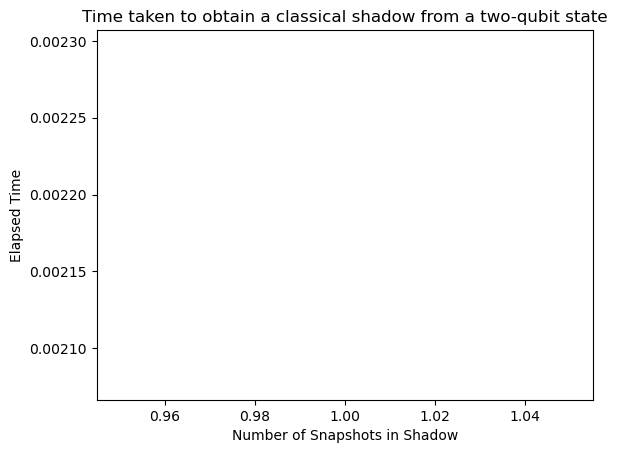

In [5]:
plt.plot(snapshot_array, elapsed_times)
plt.title("Time taken to obtain a classical shadow from a two-qubit state")
plt.xlabel("Number of Snapshots in Shadow")
plt.ylabel("Elapsed Time")
plt.show()

As one might expect, the computation time increases linearly with the
number of snapshots. This linear scaling is useful for predicting the
length of time required to obtain a sufficient number of snapshots for
observable estimation.


State Reconstruction from a Classical Shadow
============================================

To verify that the classical shadow approximates the exact state that we
want to estimate, we tomographically reconstruct the original quantum
state $\rho$ from a classical shadow. Remember that we can approximate
$\rho$ by averaging over the snapshots and applying the inverse
measurement channel,

$$\rho = \mathbb{E}\left[\mathcal{M}^{-1}(U^{\dagger}|\hat{b}\rangle\langle\hat{b}|U)\right].$$

The expectation $\mathbb{E}[\cdot]$ describes the average over the
measurement outcomes $|b\rangle$ and the sampled unitaries. Inverting
the measurement channel may seem formidable at first, however, Huang et
al. show that for Pauli measurements we end up with a rather convenient
expression,

$$\rho=\mathbb{E}[\hat{\rho}], \quad \text{where} \quad
\hat{\rho} = \bigotimes_{j=1}^n(3U^{\dagger}_j|\hat{b}_j\rangle\langle\hat{b}_j|U_j-\mathbb{I}).$$

Here $\hat{\rho}$ is a snapshot state reconstructed from a single sample
in the classical shadow, and $\rho$ is the average over all snapshot
states $\hat{\rho}$ in the shadow.

To implement the state reconstruction of $\rho$ in PennyLane, we develop
the `shadow_state_reconstruction` function.


In [6]:
def snapshot_state(b_list, obs_list):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs
     a state from a single snapshot in a shadow.

    Implements Eq. (S44) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        b_list (array): The list of classical outcomes for the snapshot.
        obs_list (array): Indices for the applied Pauli measurement.

    Returns:
        Numpy array with the reconstructed snapshot.
    """
    num_qubits = len(b_list)

    # computational basis states
    zero_state = np.array([[1, 0], [0, 0]])
    one_state = np.array([[0, 0], [0, 1]])

    # local qubit unitaries
    phase_z = np.array([[1, 0], [0, -1j]], dtype=complex)
    hadamard = qml.matrix(qml.Hadamard(0))
    identity = qml.matrix(qml.Identity(0))

    # undo the rotations that were added implicitly to the circuit for the Pauli measurements
    unitaries = [hadamard, hadamard @ phase_z, identity]

    # reconstructing the snapshot state from local Pauli measurements
    rho_snapshot = [1]
    for i in range(num_qubits):
        state = zero_state if b_list[i] == 1 else one_state
        U = unitaries[int(obs_list[i])]

        # applying Eq. (S44)
        local_rho = 3 * (U.conj().T @ state @ U) - identity
        rho_snapshot = np.kron(rho_snapshot, local_rho)

    return rho_snapshot


def shadow_state_reconstruction(shadow):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.

    Returns:
        Numpy array with the reconstructed quantum state.
    """
    num_snapshots, num_qubits = shadow[0].shape

    # classical values
    b_lists, obs_lists = shadow

    # Averaging over snapshot states.
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(b_lists[i], obs_lists[i])

    return shadow_rho / num_snapshots

Example: Reconstructing a Bell State
====================================

First, we construct a single-shot, `'lightning.qubit'` device and define
the `bell_state_circuit` QNode to construct and measure a Bell state.


In [7]:
num_qubits = 2

dev = qml.device("lightning.qubit", wires=num_qubits, shots=1)


# circuit to create a Bell state and measure it in
# the bases specified by the 'observable' keyword argument.
@qml.qnode(dev)
def bell_state_circuit(params, **kwargs):
    observables = kwargs.pop("observable")

    qml.Hadamard(0)
    qml.CNOT(wires=[0, 1])

    return [qml.expval(o) for o in observables]

Then, construct a classical shadow consisting of 1000 snapshots.


In [8]:
num_snapshots = 1000
params = []

shadow = calculate_classical_shadow(
    bell_state_circuit, params, num_snapshots, num_qubits
)
print(shadow[0])
print(shadow[1])

[[ 1.  1.]
 [ 1. -1.]
 [-1. -1.]
 ...
 [ 1. -1.]
 [-1. -1.]
 [-1. -1.]]
[[2 0]
 [0 1]
 [2 1]
 ...
 [0 2]
 [2 0]
 [1 2]]


To reconstruct the Bell state we use `shadow_state_reconstruction`.


In [9]:
shadow_state = shadow_state_reconstruction(shadow)
print(np.round(shadow_state, decimals=6))

[[ 0.523 +0.j     -0.0255-0.018j  -0.0105+0.0045j  0.4815-0.j    ]
 [-0.0255+0.018j  -0.023 +0.j      0.0675+0.009j   0.03  -0.j    ]
 [-0.0105-0.0045j  0.0675-0.009j  -0.107 +0.j      0.0015+0.018j ]
 [ 0.4815+0.j      0.03  +0.j      0.0015-0.018j   0.607 +0.j    ]]


Note the resemblance to the exact Bell state density matrix.


In [15]:
X=np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])

np.outer(X,X)

bell_state = np.array([[0.5, 0, 0, 0.5], [0, 0, 0, 0], [0, 0, 0, 0], [0.5, 0, 0, 0.5]])
bell_state

tensor([[0.5, 0. , 0. , 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0. , 0. , 0.5]], requires_grad=True)

tensor([[0.5, 0. , 0. , 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0. , 0. , 0.5]], requires_grad=True)

To measure the closeness we can use the operator norm.


In [11]:
def operator_2_norm(R):
    """
    Calculate the operator 2-norm.

    Args:
        R (array): The operator whose norm we want to calculate.

    Returns:
        Scalar corresponding to the norm.
    """
    return np.sqrt(np.trace(R.conjugate().transpose() @ R))


# Calculating the distance between ideal and shadow states.
operator_2_norm(bell_state - shadow_state)

(0.19641028486308962+0j)

Finally, we see how the approximation improves as we increase the number
of snapshots. We run the estimator 10 times for each $N$.


0 0 [[ 0.4  +0.j    -0.225-0.135j -0.015+0.06j   0.585-0.135j]
 [-0.225+0.135j  0.145+0.j     0.09 -0.09j  -0.06 -0.03j ]
 [-0.015-0.06j   0.09 +0.09j   0.04 +0.j     0.045+0.135j]
 [ 0.585+0.135j -0.06 +0.03j   0.045-0.135j  0.415+0.j   ]]
0 1 [[ 0.5395 +0.j       0.02475-0.00975j -0.0405 -0.048j    0.49725-0.04725j]
 [ 0.02475+0.00975j -0.011  +0.j       0.02025+0.02925j  0.054  +0.051j  ]
 [-0.0405 +0.048j    0.02025-0.02925j -0.0335 +0.j       0.00225-0.01425j]
 [ 0.49725+0.04725j  0.054  -0.051j    0.00225+0.01425j  0.505  +0.j     ]]
0 2 [[ 0.49225+0.j      -0.003  -0.003j    0.00125+0.006j    0.50775-0.02175j]
 [-0.003  +0.003j    0.00275+0.j       0.00075-0.00975j  0.00275+0.0015j ]
 [ 0.00125-0.006j    0.00075+0.00975j  0.00525+0.j       0.00075-0.02325j]
 [ 0.50775+0.02175j  0.00275-0.0015j   0.00075+0.02325j  0.49975+0.j     ]]
1 0 [[ 0.3775+0.00000000e+00j  0.06  +6.75000000e-02j  0.0975+9.00000000e-02j
   0.765 -2.25000000e-02j]
 [ 0.06  -6.75000000e-02j -0.0275+0.00000000

<ErrorbarContainer object of 3 artists>

Text(0.5, 1.0, 'Distance between Ideal and Shadow Bell States')

Text(0.5, 0, 'Number of Snapshots')

Text(0, 0.5, 'Distance')

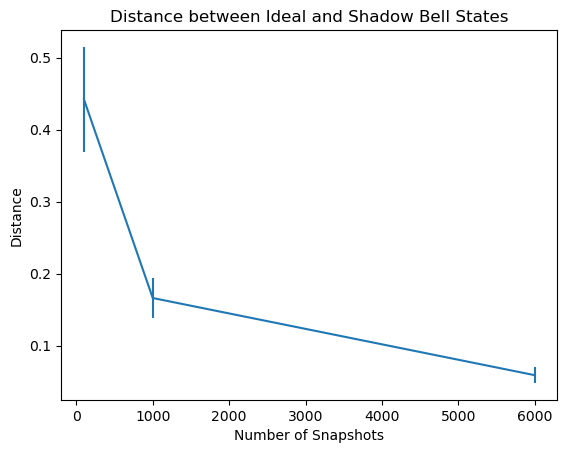

In [13]:
number_of_runs = 10
snapshots_range = [100, 1000, 6000]
distances = np.zeros((number_of_runs, len(snapshots_range)))

# run the estimation multiple times so that we can include error bars
for i in range(number_of_runs):
    for j, num_snapshots in enumerate(snapshots_range):
        shadow = calculate_classical_shadow(
            bell_state_circuit, params, num_snapshots, num_qubits
        )
        shadow_state = shadow_state_reconstruction(shadow)
        print(i,j,shadow_state)
        distances[i, j] = np.real(operator_2_norm(bell_state - shadow_state))

plt.errorbar(
    snapshots_range,
    np.mean(distances, axis=0),
    yerr=np.std(distances, axis=0),
)
plt.title("Distance between Ideal and Shadow Bell States")
plt.xlabel("Number of Snapshots")
plt.ylabel("Distance")
plt.show()

As expected, when the number of snapshots increases, the state
reconstruction becomes closer to the ideal state.


Estimating Pauli Observables with Classical Shadows
===================================================

We have confirmed that classical shadows can be used to reconstruct the
state. However, the goal of classical shadows is not to perform full
tomography, which takes an exponential amount of resources. Instead, we
want to use the shadows to efficiently calculate linear functions of a
quantum state. To do this, we write a function
`estimate_shadow_observable` that takes in the previously constructed
shadow $S(\rho, N)=[\hat{\rho}_1,\hat{\rho}_2,\ldots,\hat{\rho}_N]$, and
estimates any observable via a median of means estimation. This makes
the estimator more robust to outliers and is required to formally prove
the aforementioned theoretical bound. The procedure is simple: split up
the shadow into $K$ equally sized chunks and estimate the mean for each
of these chunks,

$$\langle O_{(k)}\rangle = \text{Tr}\{O \hat{\rho}_{(k)}\} \quad
\text{and} \quad \hat{\rho}_{(k)} = \frac{1}{ \lfloor N/K \rfloor }
\sum_{i=(k-1)\lfloor N/K \rfloor + 1}^{k \lfloor N/K \rfloor } \hat{\rho}_i.$$

The median of means estimator is then simply the median of this set

$$\langle O\rangle = \text{median}\{\langle O_{(1)} \rangle,\ldots, \langle O_{(K)} \rangle \}.$$

Note that the shadow bound has a failure probability $\delta$. By
choosing the number of splits $K$ to be suitably large, we can
exponentially suppress this failure probability. Assume now that
$O=\bigotimes_j^n P_j$, where $P_j \in \{I, X, Y, Z\}$. To efficiently
calculate the estimator for $O$, we look at a single snapshot outcome
and plug in the inverse measurement channel:

$$\begin{aligned}
\text{Tr}\{O\hat{\rho}_i\} &= \text{Tr}\{\bigotimes_{j=1}^n P_j (3U^{\dagger}_j|\hat{b}_j\rangle\langle\hat{b}_j|U_j-\mathbb{I})\}\\
 &= \prod_j^n \text{Tr}\{ 3 P_j U^{\dagger}_j|\hat{b}_j\rangle\langle\hat{b}_j|U_j\}.
\end{aligned}$$

Due to the orthogonality of the Pauli operators, this evaluates to
$\pm 3$ if $P_j$ is the corresponding measurement basis $U_j$ and 0
otherwise. Hence if a single $U_j$ in the snapshot does not match the
one in $O$, the whole product evaluates to zero. As a result,
calculating the mean estimator can be reduced to counting the number of
exact matches in the shadow with the observable, and multiplying with
the appropriate sign. Below, we develop the function
`estimate_shadow_obervable` to estimate any observable given a classical
shadow.


In [ ]:
def estimate_shadow_obervable(shadow, observable, k=10):
    """
    Adapted from https://github.com/momohuang/predicting-quantum-properties
    Calculate the estimator E[O] = median(Tr{rho_{(k)} O}) where rho_(k)) is set of k
    snapshots in the shadow. Use median of means to ameliorate the effects of outliers.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.
        observable (qml.Observable): Single PennyLane observable consisting of single Pauli
            operators e.g. qml.PauliX(0) @ qml.PauliY(1).
        k (int): number of splits in the median of means estimator.

    Returns:
        Scalar corresponding to the estimate of the observable.
    """
    shadow_size, num_qubits = shadow[0].shape

    # convert Pennylane observables to indices
    map_name_to_int = {"PauliX": 0, "PauliY": 1, "PauliZ": 2}
    if isinstance(observable, (qml.PauliX, qml.PauliY, qml.PauliZ)):
        target_obs, target_locs = np.array(
            [map_name_to_int[observable.name]]
        ), np.array([observable.wires[0]])
    else:
        target_obs, target_locs = np.array(
            [map_name_to_int[o.name] for o in observable.obs]
        ), np.array([o.wires[0] for o in observable.obs])

    # classical values
    b_lists, obs_lists = shadow
    means = []

    # loop over the splits of the shadow:
    for i in range(0, shadow_size, shadow_size // k):

        # assign the splits temporarily
        b_lists_k, obs_lists_k = (
            b_lists[i: i + shadow_size // k],
            obs_lists[i: i + shadow_size // k],
        )

        # find the exact matches for the observable of interest at the specified locations
        indices = np.all(obs_lists_k[:, target_locs] == target_obs, axis=1)

        # catch the edge case where there is no match in the chunk
        if sum(indices) > 0:
            # take the product and sum
            product = np.prod(b_lists_k[indices][:, target_locs], axis=1)
            means.append(np.sum(product) / sum(indices))
        else:
            means.append(0)

    return np.median(means)

Next, we can define a function that calculates the number of samples
required to get an error $\epsilon$ on our estimator for a given set of
observables.


In [ ]:
def shadow_bound(error, observables, failure_rate=0.01):
    """
    Calculate the shadow bound for the Pauli measurement scheme.

    Implements Eq. (S13) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        error (float): The error on the estimator.
        observables (list) : List of matrices corresponding to the observables we intend to
            measure.
        failure_rate (float): Rate of failure for the bound to hold.

    Returns:
        An integer that gives the number of samples required to satisfy the shadow bound and
        the chunk size required attaining the specified failure rate.
    """
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(o) for o in observables) / error ** 2
    return int(np.ceil(N * K)), int(K)

Example: Estimating a simple set of observables
===============================================

Here, we give an example for estimating multiple observables on a
10-qubit circuit. We first create a simple circuit


In [ ]:
num_qubits = 10
dev = qml.device("lightning.qubit", wires=num_qubits, shots=1)


def circuit_base(params, **kwargs):
    observables = kwargs.pop("observable")
    for w in range(num_qubits):
        qml.Hadamard(wires=w)
        qml.RY(params[w], wires=w)
    for w in dev.wires[:-1]:
        qml.CNOT(wires=[w, w + 1])
    for w in dev.wires:
        qml.RZ(params[w + num_qubits], wires=w)
    return [qml.expval(o) for o in observables]


circuit = qml.QNode(circuit_base, dev)

params = np.random.randn(2 * num_qubits)

Next, we define our set of observables

$$O = \sum_{i=0}^{n-1} X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1}.$$


In [ ]:
list_of_observables = (
        [qml.PauliX(i) @ qml.PauliX(i + 1) for i in range(num_qubits - 1)]
        + [qml.PauliY(i) @ qml.PauliY(i + 1) for i in range(num_qubits - 1)]
        + [qml.PauliZ(i) @ qml.PauliZ(i + 1) for i in range(num_qubits - 1)]
)

With the `shadow_bound` function, we calculate how many shadows we need
to ensure that the absolute error of all individual terms in $O$
satisfies

$$|\langle{O_i}\rangle_{shadow} - \langle{O_i}\rangle_{exact}| \leq \epsilon$$

for all $1\leq i \leq M$.


In [ ]:
shadow_size_bound, k = shadow_bound(
    error=2e-1, observables=[qml.matrix(o) for o in list_of_observables]
)
shadow_size_bound

We verify the bound by considering a grid of errors $\epsilon_i$ and
checking that
$|\langle{O_i}\rangle_{shadow} - \langle{O_i}\rangle_{exact}|$ stays
below this value for the shadow size calculated in `shadow_bound`.
First, we get the classical shadow estimate.


In [ ]:
# create a grid of errors
epsilon_grid = [1 - 0.1 * x for x in range(9)]
shadow_sizes = []
estimates = []

for error in epsilon_grid:
    # get the number of samples needed so that the absolute error < epsilon.
    shadow_size_bound, k = shadow_bound(
        error=error, observables=[qml.matrix(o) for o in list_of_observables]
    )
    shadow_sizes.append(shadow_size_bound)
    print(f"{shadow_size_bound} samples required ")
    # calculate a shadow of the appropriate size
    shadow = calculate_classical_shadow(circuit, params, shadow_size_bound, num_qubits)

    # estimate all the observables in O
    estimates.append([estimate_shadow_obervable(shadow, o, k=k) for o in list_of_observables])

Then, we calculate the ground truth by changing the device backend.


In [ ]:
dev_exact = qml.device("lightning.qubit", wires=num_qubits)
# change the simulator to be the exact one.
circuit = qml.QNode(circuit_base, dev_exact)

expval_exact = [
    circuit(params, observable=[o]) for o in list_of_observables
]

Finally, we plot the errors
$|\langle{O_i}\rangle_{shadow} - \langle{O_i}\rangle_{exact}|$ for all
individual terms in $O$. We expect that these errors are always smaller
than $\epsilon$.


In [ ]:
for j, error in enumerate(epsilon_grid):
    plt.scatter(
        [shadow_sizes[j] for _ in estimates[j]],
        [np.abs(obs - estimates[j][i]) for i, obs in enumerate(expval_exact)],
        marker=".",
    )
plt.plot(
    shadow_sizes,
    [e for e in epsilon_grid],
    linestyle="--",
    color="gray",
    label=rf"$\epsilon$",
    marker=".",
)
plt.xlabel(r"$N$ (Shadow size) ")
plt.ylabel(r"$|\langle O_i \rangle_{exact} - \langle O_i \rangle_{shadow}|$")
plt.legend()
plt.show()

The points in the plot indicate the individual errors for all $O_i$ at a
given shadow size. The dashed line represents the error threshold that
these points must stay under to satisfy the bound. As expected, the
bound is satisfied for all $O_i$ and the errors decrease with the size
of the shadow.

To conclude, we have shown that classical shadows can be used to
reconstruct quantum states and estimate expectation values of
observables. This is but the tip of the iceberg of what is possible with
this technique. In the original work, the authors estimate fidelities,
calculate entanglement witnesses, and even find a way to approximate the
von Neumann entropy. These applications illustrate the potential power
of classical shadows for the characterization of quantum systems.


References
==========

About the authors
=================
